In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb
import catboost as cb
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
#!pip install lightgbm
#!pip install catboost
#!pip install xgboost

In [14]:
# Load data
data = pd.read_excel(r"C:\Users\HP\Desktop\Capstone Project\Transformed_Data_16-03-2025.xlsx", sheet_name=0)
print("Available columns:", data.columns)

# Convert AQHI to numeric, coercing errors to NaN
data['AQHI'] = pd.to_numeric(data['AQHI'], errors='coerce')

# Check for null values before removal
print("\nNull values in each column before removal:")
print(data.isna().sum())
print("Total rows before removal:", len(data))

# Remove rows with any NaN values
data_cleaned = data.dropna()
print("\nNull values in each column after removal:")
print(data_cleaned.isna().sum())
print("Total rows after removal:", len(data_cleaned))

# Keep only numeric columns
numeric_data = data_cleaned.select_dtypes(include=[np.number])
print("\nNumeric data preview (first 5 rows):")
print(numeric_data.head())

Available columns: Index(['Station ID', 'Date', 'Time', 'TimeStamp', 'PM2.5', 'SO2', 'O3', 'NO2',
       'CO', 'NO', 'AQHI'],
      dtype='object')

Null values in each column before removal:
Station ID     0
Date           0
Time           0
TimeStamp      0
PM2.5          0
SO2            0
O3             0
NO2            0
CO             0
NO             0
AQHI          24
dtype: int64
Total rows before removal: 26280

Null values in each column after removal:
Station ID    0
Date          0
Time          0
TimeStamp     0
PM2.5         0
SO2           0
O3            0
NO2           0
CO            0
NO            0
AQHI          0
dtype: int64
Total rows after removal: 26256

Numeric data preview (first 5 rows):
   Station ID  PM2.5  SO2    O3   NO2    CO    NO  AQHI
0       12008   29.0  0.1   6.0  31.0  0.30  15.5   2.0
1       12008   23.0  0.1  10.0  26.1  0.30   5.6   2.0
2       12008   20.0  0.0  14.0  20.5  0.25   2.2   2.0
3       12008   18.0  0.0  12.0  23.1  0.25   2.5

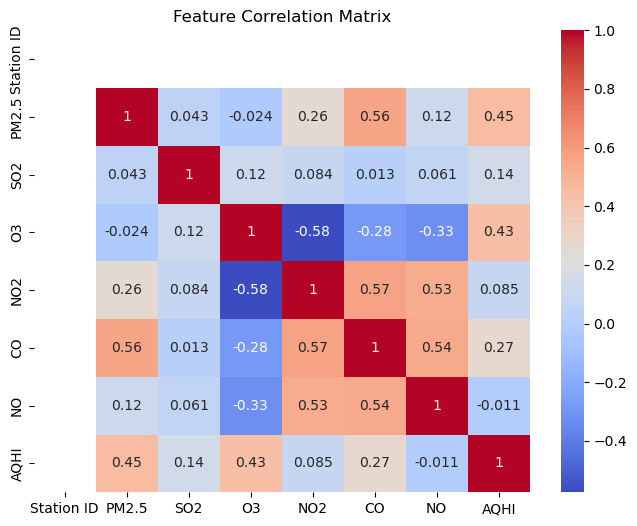

In [16]:
# Check correlation and select features
corr_matrix = numeric_data.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

In [40]:
# Select features with correlation > 0.2 with AQHI
correlated_features = corr_matrix['AQHI'].abs().sort_values(ascending=False)
selected_features = correlated_features[correlated_features > 0.2].index.tolist()
selected_features.remove('AQHI')
print("Selected features:", selected_features)

# Prepare data
X = numeric_data[selected_features]
y = numeric_data['AQHI']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models with additional models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "LightGBM": lgb.LGBMRegressor(n_estimators=100, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "CatBoost": cb.CatBoostRegressor(n_estimators=100, random_state=42, verbose=0),
    "AdaBoost": AdaBoostRegressor(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBRegressor(n_estimators=100, random_state=42)
}

# Function to compute metrics
def compute_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2

# Train and evaluate models
results = {}
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on training and test sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Compute metrics for training set
    train_mae, train_mse, train_rmse, train_r2 = compute_metrics(y_train, y_train_pred)
    
    # Compute metrics for test set
    test_mae, test_mse, test_rmse, test_r2 = compute_metrics(y_test, y_test_pred)
    
    # Store results
    results[name] = {
        "Train MAE": train_mae, "Train MSE": train_mse, "Train RMSE": train_rmse, "Train R²": train_r2,
        "Test MAE": test_mae, "Test MSE": test_mse, "Test RMSE": test_rmse, "Test R²": test_r2
    }
    
    print(f"\n{name}:")
    print(f"Training Set - MAE: {train_mae:.2f}, MSE: {train_mse:.2f}, RMSE: {train_rmse:.2f}, R²: {train_r2:.4f}")
    print(f"Test Set - MAE: {test_mae:.2f}, MSE: {test_mse:.2f}, RMSE: {test_rmse:.2f}, R²: {test_r2:.4f}")

Selected features: ['PM2.5', 'O3', 'CO']

Linear Regression:
Training Set - MAE: 0.50, MSE: 0.42, RMSE: 0.65, R²: 0.4364
Test Set - MAE: 0.50, MSE: 0.43, RMSE: 0.65, R²: 0.4200

Decision Tree:
Training Set - MAE: 0.20, MSE: 0.13, RMSE: 0.37, R²: 0.8208
Test Set - MAE: 0.53, MSE: 0.62, RMSE: 0.79, R²: 0.1611

Gradient Boosting:
Training Set - MAE: 0.46, MSE: 0.35, RMSE: 0.59, R²: 0.5270
Test Set - MAE: 0.47, MSE: 0.39, RMSE: 0.63, R²: 0.4687
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000728 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 426
[LightGBM] [Info] Number of data points in the train set: 21004, number of used features: 3
[LightGBM] [Info] Start training from score 2.837793

LightGBM:
Training Set - MAE: 0.44, MSE: 0.33, RMSE: 0.57, R²: 0.5592
Test Set - MAE: 0.47, MSE: 0.38, RMSE: 0.62, R²: 0.4802

Random Forest:
Training Set - MAE: 0.28, MSE: 0.16, RMSE: 0.40, R²: 0.7846
Test Set - M

In [62]:
# Display results in a DataFrame
results_df = pd.DataFrame(results).T
print("\nModel Comparison:")
print(results_df.round(4))


Model Comparison:
                   Train MAE  Train MSE  Train RMSE  Train R²  Test MAE  \
Linear Regression     0.4993     0.4206      0.6486    0.4364    0.5020   
Decision Tree         0.2048     0.1337      0.3657    0.8208    0.5282   
Gradient Boosting     0.4609     0.3530      0.5941    0.5270    0.4737   
LightGBM              0.4425     0.3290      0.5736    0.5592    0.4668   
Random Forest         0.2848     0.1608      0.4010    0.7846    0.4970   
CatBoost              0.4433     0.3279      0.5726    0.5607    0.4676   
AdaBoost              0.5519     0.4822      0.6944    0.3540    0.5590   
XGBoost               0.4105     0.2887      0.5373    0.6132    0.4681   

                   Test MSE  Test RMSE  Test R²  
Linear Regression    0.4272     0.6536   0.4200  
Decision Tree        0.6179     0.7860   0.1611  
Gradient Boosting    0.3913     0.6256   0.4687  
LightGBM             0.3829     0.6188   0.4802  
Random Forest        0.4620     0.6797   0.3728  
CatBo

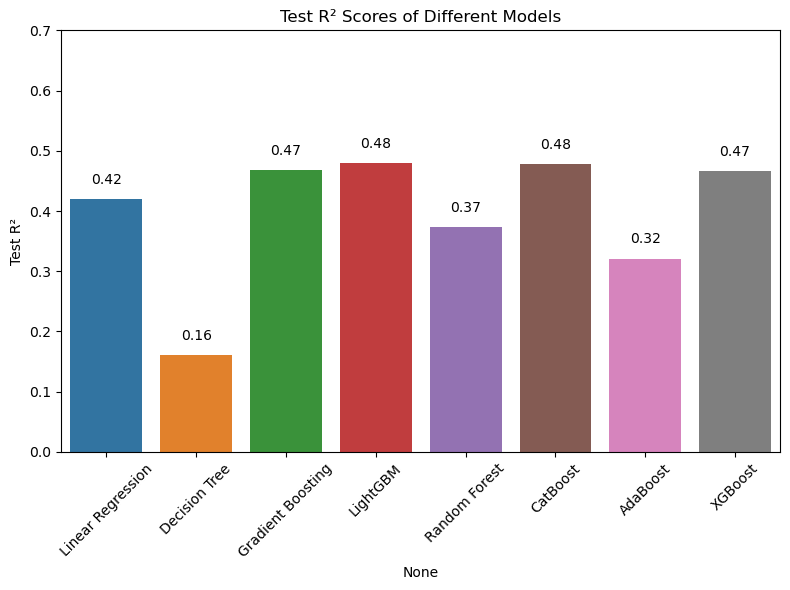

In [74]:
# Plot Test R² Scores of Different Models
plt.figure(figsize=(8, 6))
sns.barplot(x=results_df.index, y=results_df['Test R²'], hue=results_df.index)

# Add labels on top of the bars, ensuring they fit within the chart area
for index, value in enumerate(results_df['Test R²']):
    plt.text(index, value + 0.02, f'{value:.2f}', ha='center', va='bottom', fontsize=10)

# Set labels and title
plt.xticks(rotation=45)
plt.title("Test R² Scores of Different Models")
plt.ylim(0, 0.7)  # Adjust y-axis to ensure labels are within view (adjust the upper limit as needed)
plt.tight_layout()  # Ensure everything fits
plt.show()

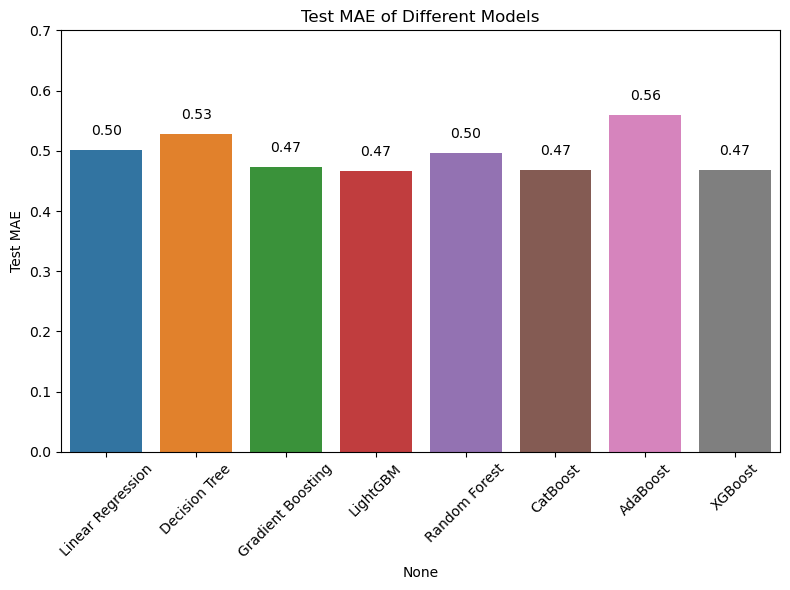

In [86]:
# Plot Test MAE of Different Models
plt.figure(figsize=(8, 6))
sns.barplot(x=results_df.index, y=results_df['Test MAE'], hue=results_df.index)

# Add labels on top of the bars, ensuring they fit within the chart area
for index, value in enumerate(results_df['Test MAE']):
    # Adding label with a safe margin
    plt.text(index, value + 0.02, f'{value:.2f}', ha='center', va='bottom', fontsize=10)

# Set labels and title
plt.xticks(rotation=45)
plt.title("Test MAE of Different Models")
plt.ylim(0, 0.7)  # Adjust y-axis to ensure labels are within view (adjust the upper limit as needed)
plt.tight_layout()  # Ensure everything fits
plt.show()